In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_stata('chip2013.dta')
df['const'] = 1
df.head()

,hhcode,earning_ann,earning_mon,female,school,age,age_sq,prov,city,const
0,1101010208301,26400.0,2200.0,1.0,11.0,24.0,5.760000,11,01,1
1,1101010209701,36000.0,3000.0,0.0,11.0,50.0,25.000000,11,01,1
2,1101010209701,60000.0,5000.0,1.0,11.0,46.0,21.160000,11,01,1
3,1101010209701,42000.0,3500.0,1.0,14.0,47.0,22.090000,11,01,1
4,1101010209701,72000.0,6000.0,0.0,15.0,48.0,23.040001,11,01,1


In [3]:
sample = df[df['prov']=='11']
reg1 = sm.OLS(endog=sample['earning_mon'], exog=sample[['const', 'age', 'age_sq', 'female', 
                                                                'school']], missing='drop')
result1 = reg1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:            earning_mon   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     53.65
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           1.97e-40
Time:                        20:30:22   Log-Likelihood:                -8211.3
No. Observations:                 873   AIC:                         1.643e+04
Df Residuals:                     868   BIC:                         1.646e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9111.8337   1794.894     -5.077      0.0

In [4]:
y_pred = result1.predict(exog=sample[['const','age','age_sq','female','school']])

In [5]:
from sklearn.metrics import mean_squared_error
import sklearn.linear_model
from sklearn.model_selection import KFold
kf = KFold(n_splits=4, shuffle=True, random_state=10)

In [6]:
prov_list = ["11", "14", "21", "32", "34", "37", "41", "42", "43", "44", "50", "51", "53", "62"]
mse_vec = {}

In [62]:
# compute OLS mse
mse_OLS = []
for prov_code in prov_list:
    sample = df[df['prov']==prov_code]
    reg = sm.OLS(endog=sample['earning_mon'], exog=sample[['const', 'age', 'age_sq', 'female', 
                                                            'school']], missing='drop')
    result = reg.fit()    
    y_pred = result.predict(exog=sample[['const','age','age_sq','female','school']])
    mse_OLS.append(mean_squared_error(sample['earning_mon'],y_pred))
    # df[prov_code] = result.predict(exog = df[['const','age','age_sq','female','school']])
mse_vec['OLS'] = np.array(mse_OLS).mean()
mse_vec

{'OLS': 10607887.003603922}

# Lasso

In [13]:
# choose the best alpha for lasso regression using k-fold cross validation, k=4
alpha_vec = np.linspace(0.1, 100, 100)

In [9]:
mse_lasso = []
for a in alpha_vec:
    lasso_model = sklearn.linear_model.Lasso(alpha=a)
    mse_nation = 0
    # because we have 14 provinces, so we have 14 regressions. mse is sumed up.
    for prov_code in prov_list: 
        sample = df[df['prov']==prov_code]
        X = sample[['age', 'age_sq', 'female', 'school']].values
        y = sample['earning_mon'].values
        mse_prov = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]        
            lasso_model.fit(X_train, y_train)    
            y_pred = lasso_model.predict(X_test)
            mse_prov += mean_squared_error(y_test,y_pred)
        # df[prov_code] = result.predict(exog = df[['const','age','age_sq','female','school']])
        mse_nation += mse_prov / 4
    mse_lasso.append(mse_nation / 14)

C:\Users\nanka\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\nanka\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\nanka\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [10]:
alpha_star_lasso = alpha_vec[np.where(mse_lasso == np.amin(mse_lasso))[0]]
print(alpha_star_lasso)

[6.15454545]


In [126]:
# compute mse using the best selected alpha
mse_lasso = []
lasso_model_star = sklearn.linear_model.Lasso(alpha=alpha_star_lasso)
for prov_code in prov_list: 
    sample = df[df['prov']==prov_code]
    X = sample[['age', 'age_sq', 'female', 'school']]
    y = sample['earning_mon']
    lasso_model_star.fit(X, y)
    y_pred = lasso_model_star.predict(X)
    mse_lasso.append(mean_squared_error(y, y_pred))
print(np.array(mse_lasso).mean())
mse_vec['Lasso'] = np.array(mse_lasso).mean()

10608163.700335298


# Ridge

In [11]:
# select best alpha using k-fold cross validation, k=4
mse_ridge = []
for a in alpha_vec:
    ridge_model = sklearn.linear_model.Ridge(alpha=a)
    mse_nation = 0
    for prov_code in prov_list: 
        sample = df[df['prov']==prov_code]
        X = sample[['age', 'age_sq', 'female', 'school']].values
        y = sample['earning_mon'].values
        mse_prov = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]        
            ridge_model.fit(X_train, y_train)    
            y_pred = ridge_model.predict(X_test)
            mse_prov += mean_squared_error(y_test,y_pred)
        # df[prov_code] = result.predict(exog = df[['const','age','age_sq','female','school']])
        mse_nation += mse_prov / 4
    mse_ridge.append(mse_nation / 14)

In [12]:
alpha_star_ridge = alpha_vec[np.where(mse_ridge == np.amin(mse_ridge))[0]]
print(alpha_star_ridge)

[29.36363636]


In [129]:
# compute mse using best selected alpha
mse_ridge = []
ridge_model_star = sklearn.linear_model.Ridge(alpha=alpha_star_ridge)
for prov_code in prov_list: 
    sample = df[df['prov']==prov_code]
    X = sample[['age', 'age_sq', 'female', 'school']].values
    y = sample['earning_mon'].values
    ridge_model_star.fit(X, y)
    y_pred = ridge_model_star.predict(X)
    mse_ridge.append(mean_squared_error(y, y_pred))
print(np.array(mse_ridge).mean())
mse_vec['Ridge'] = np.array(mse_ridge).mean()

10613054.0


In [130]:
mse_vec

{'OLS': 10607887.003603922, 'Lasso': 10608163.700335298, 'Ridge': 10613054.0}

# Random Forest

In [132]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint

In [133]:
param_dist = {'n_estimators': [10, 200],
               'max_depth': [3, 10],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20),
               'max_features': sp_randint(1, 5)}

In [134]:
X = df[['age', 'age_sq', 'female', 'school']].values
y = df['earning_mon'].values

In [135]:
# selected best parameters for random forest regression
hittree = RandomForestRegressor(random_state=25)
random_search = \
    RandomizedSearchCV(hittree, param_distributions=param_dist,
                       n_iter=100, n_jobs=-1, cv=4, random_state=25,
                       scoring='neg_mean_squared_error')
random_search.fit(X, y)

RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=25, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 200], 'max_depth': [3, 10], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A73DAEE978>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A73DAEE9B0>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A73DAEEC50>},
          pre_dispatch='2*n_jobs', random_state=25, refit=True,
          return_train_score='warn', scor

In [136]:
print('RandBestParams1 (whole data set) =', random_search.best_params_)

RandBestParams1 (whole data set) = {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 13, 'min_samples_split': 10, 'n_estimators': 200}


In [137]:
mse_rf = []
rf_model_star = RandomForestRegressor(max_depth=3,max_features=3, min_samples_leaf=13,min_samples_split=10,n_estimators=200)
# predict individual earning in each province
for prov_code in prov_list: 
    sample = df[df['prov']==prov_code]
    X = sample[['age', 'age_sq', 'female', 'school']].values
    y = sample['earning_mon'].values
    rf_model_star.fit(X, y)
    y_pred = rf_model_star.predict(X)
    mse_rf.append(mean_squared_error(y, y_pred))
print(np.array(mse_rf).mean())
mse_vec['Random Forest'] = np.array(mse_rf).mean()

10162166.025653824


In [142]:
pd.DataFrame.from_dict(mse_vec,orient='index')

,0
OLS,1.060789e+07
Lasso,1.060816e+07
Ridge,1.061305e+07
Random Forest,1.016217e+07


In [192]:
mse_vec

{'OLS': 10607887.003603922,
 'Lasso': 10608163.700335298,
 'Ridge': 10613054.0,
 'Random Forest': 10162166.025653824}

In [176]:
mse_rescaled = []
for num in mse_vec.values():
    num = (num - 10000000)
    mse_rescaled.append(num)
mse_rescaled

[607887.0036039222, 608163.7003352977, 613054.0, 162166.0256538242]

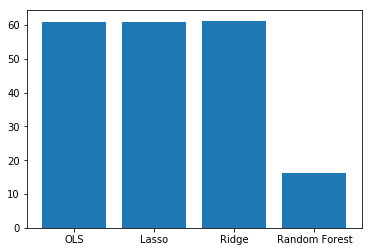

In [173]:
plt.bar(mse_vec.keys(),mse_rescaled);

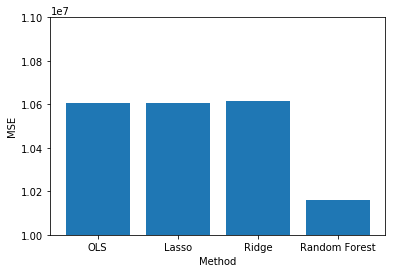

In [182]:
plt.ylim([10000000, 11000000])
plt.bar(mse_vec.keys(),mse_vec.values())
plt.ylabel('MSE')
plt.xlabel('Method')
plt.savefig('MSE');

# Location cost

In [187]:
X = df[['age', 'age_sq', 'female', 'school']].values
y = df['earning_mon'].values
df2 = df.copy()
for prov_code in prov_list: 
    sample = df[df['prov']==prov_code]
    X_sample = sample[['age', 'age_sq', 'female', 'school']].values
    y_sample = sample['earning_mon'].values
    rf_model_star.fit(X_sample, y_sample)   
    df2[prov_code] = rf_model_star.predict(X)

In [189]:
df2.to_stata('finaldata.dta') 
# some simple modification is done by STATA because it is easier
# location cost is computed in stata program

C:\Users\nanka\Anaconda3\lib\site-packages\pandas\io\stata.py:2138: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    b'const'   ->   _const
    b'11'   ->   _11
    b'14'   ->   _14
    b'21'   ->   _21
    b'32'   ->   _32
    b'34'   ->   _34
    b'37'   ->   _37
    b'41'   ->   _41
    b'42'   ->   _42
    b'43'   ->   _43
    b'44'   ->   _44
    b'50'   ->   _50
    b'51'   ->   _51
    b'53'   ->   _53
    b'62'   ->   _62

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  warnings.warn(ws, InvalidColumnName)


# After merge

In [7]:
df3 = pd.read_stata('merge_hsr.dta')
df3.head()

,index,hhcode,earning_ann,earning_mon,female,school,age,age_sq,prov,prov_num,...,earning_home,prov_max,prov_max_num,earning_max,cost,costbyprov,earnbyprov,link,_merge,transport
0,8679,6209021201801,42000.0,3500.000000,0.0,14.0,38.0,14.440000,62,62,...,3533.469238,32,32,5990.144043,2456.674805,2271.944336,2716.587158,3262,master only (1),0.0
1,5050,4201110809601,33600.0,5600.000000,1.0,9.0,47.0,22.090000,42,42,...,2466.287109,11,11,3114.777344,648.490234,1820.712769,3308.703613,1142,master only (1),0.0
2,5522,4301110206601,35000.0,2916.666748,0.0,15.0,44.0,19.360001,43,43,...,4047.834473,44,44,6803.185547,2755.351074,1944.690430,3390.797363,4344,master only (1),0.0
3,5192,4207040103601,22000.0,1833.333374,1.0,14.0,29.0,8.410000,42,42,...,2929.969971,11,11,4665.355957,1735.385986,1820.712769,3308.703613,1142,master only (1),0.0
4,965,1401810401801,26400.0,2200.000000,0.0,9.0,50.0,25.000000,14,14,...,3103.391113,44,44,4482.785156,1379.394043,1913.964111,2919.061035,1444,master only (1),0.0


In [29]:
cost_dict = dict()
for prov_code in prov_list:
    cost = df3[df3['prov'] == prov_code]['cost'].mean()
    cost_dict[prov_code] = cost
cost_dict # average location cost in each province

{'11': 1044.6009521484375,
 '14': 1913.96240234375,
 '21': 1811.2672119140625,
 '32': 911.2861328125,
 '34': 1605.8302001953125,
 '37': 1823.08544921875,
 '41': 2216.79638671875,
 '42': 1820.714111328125,
 '43': 1944.6900634765625,
 '44': 659.3367919921875,
 '50': 1826.6346435546875,
 '51': 1730.3861083984375,
 '53': 2284.951904296875,
 '62': 2271.945068359375}

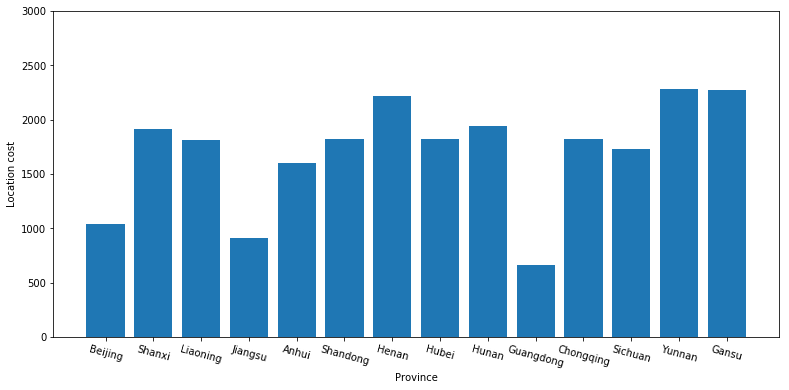

In [35]:
fig = plt.figure(figsize=(13,6))
plt.bar(['Beijing','Shanxi','Liaoning','Jiangsu','Anhui','Shandong','Henan','Hubei','Hunan','Guangdong','Chongqing',
        'Sichuan','Yunnan','Gansu'],cost_dict.values())
plt.ylim(0,3000)
plt.xlabel('Province')
plt.ylabel('Location cost')
plt.xticks(rotation=-15)
plt.savefig('bar_cost');

In [5]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut

In [16]:
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                  {'bandwidth': bandwidths},
                    cv=4)
df_trans = df3[df3['transport'] == 1]['cost'].values/100
df_notrans = df3[df3['transport'] == 0]['cost'].values/100
df_trans_nozero = df3.loc[(df3.transport==1)&(df3.cost!=0),'cost'].values/100

In [19]:
df_trans = df_trans.reshape(2194,1)
df_notrans = df_notrans.reshape(6565,1)
df_trans_nozero = df_trans_nozero.reshape(1494,1)

In [4]:
# grid.fit(df_trans);
# opt_bandwidth_trans = grid.best_params_['bandwidth']
# print(f'The best bandwidth for the trans is {opt_bandwidth_trans}')

# grid.fit(df_notrans);
# opt_bandwidth_notrans = grid.best_params_['bandwidth']
# print(f'The best bandwidth for the no trans is {opt_bandwidth_notrans}')

In [23]:
kde_trans =  KernelDensity(bandwidth=1, kernel='gaussian')
kde_trans_nozero =  KernelDensity(bandwidth=1, kernel='gaussian')
kde_notrans =  KernelDensity(bandwidth=1, kernel='gaussian')
kde_trans.fit(df_trans)
kde_trans_nozero.fit(df_trans_nozero)
kde_notrans.fit(df_notrans)

KernelDensity(algorithm='auto', atol=0, bandwidth=1, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

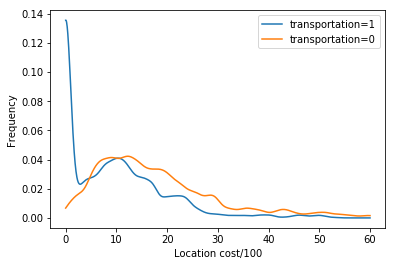

In [25]:
# compare all samples
x_pts = np.linspace(0.01, 60, 1000).reshape(1000,1)
logprob_trans = kde_trans.score_samples(x_pts).reshape((1000,1))
logprob_notrans = kde_notrans.score_samples(x_pts).reshape((1000,1))
plt.plot(x_pts, np.exp(logprob_trans), label='transportation=1')
plt.plot(x_pts, np.exp(logprob_notrans), label='transportation=0')
plt.xlabel('Location cost/100')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('kernel_density');

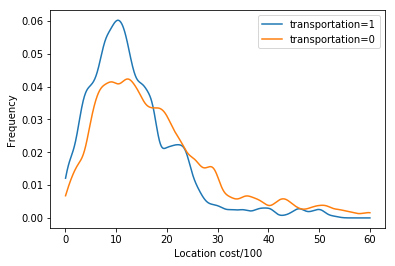

In [26]:
# Only compare within those cost!=0
x_pts = np.linspace(0.01, 60, 1000).reshape(1000,1)
logprob_trans_nozero = kde_trans_nozero.score_samples(x_pts).reshape((1000,1))
logprob_notrans = kde_notrans.score_samples(x_pts).reshape((1000,1))
plt.plot(x_pts, np.exp(logprob_trans_nozero), label='transportation=1')
plt.plot(x_pts, np.exp(logprob_notrans), label='transportation=0')
plt.xlabel('Location cost/100')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('kernel_density_nozero');

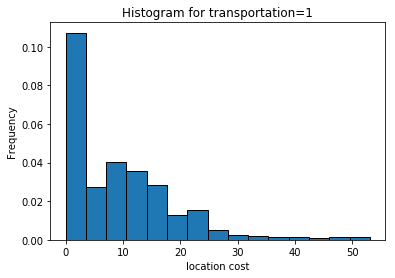

In [249]:
hist = plt.hist(df_trans, bins=15, density=True, edgecolor='black')
plt.title("Histogram for transportation=1")
plt.xlabel('location cost')
plt.ylabel('Frequency');

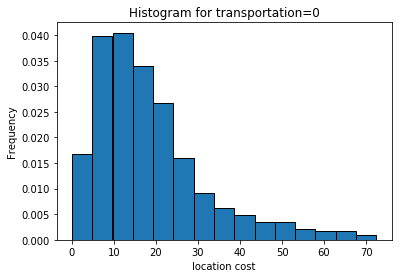

In [250]:
hist = plt.hist(df_notrans, bins=15, density=True, edgecolor='black')
plt.title("Histogram for transportation=0")
plt.xlabel('location cost')
plt.ylabel('Frequency');